In [1]:
import os, sys, time, copy, datetime
from pathlib import Path
from tqdm.auto import tqdm
tqdm.pandas()

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn import model_selection
from sklearn import linear_model
from sklearn import ensemble
from sklearn import metrics
from sklearn.utils.class_weight import compute_class_weight

import xgboost as xgb

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer

c:\Users\ADE17\anaconda3\anaconda2\envs\kaggle\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_df = pd.read_csv('../train.csv')
greek_df = pd.read_csv('../greeks.csv')
test_df = pd.read_csv('../test.csv')
sample_df = pd.read_csv('../sample_submission.csv')
print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")
print(f"Greek shape: {greek_df.shape}")

Train shape: (617, 58)
Test shape: (5, 57)
Greek shape: (617, 6)


In [3]:
train_df.head()

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,...,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,...,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,...,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,...,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,...,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1


In [4]:
print("Missing values in train set: ", train_df.isna().sum().sum())
print(f"Missing values in test set: {test_df.isna().sum().sum()}")
print(f"Missing values in greek set: {greek_df.isna().sum().sum()}")

Missing values in train set:  131
Missing values in test set: 0
Missing values in greek set: 0


In [5]:
train_df['EJ'] = train_df['EJ'].factorize()[0]
test_df['EJ'] = test_df['EJ'].factorize()[0]

In [6]:
FEATURES = []
means = {}; stds = {}; nans = {};

for c in train_df.columns[1:-1]:
    m = train_df[c].mean()
    means[c] = m
    
    s = train_df[c].std()
    stds[c] = s
    
    train_df[c] = (train_df[c] - m)/s
    n = train_df[c].min() - 0.5
    nans[c] = n
    train_df[c].fillna(n)
    FEATURES.append(c)

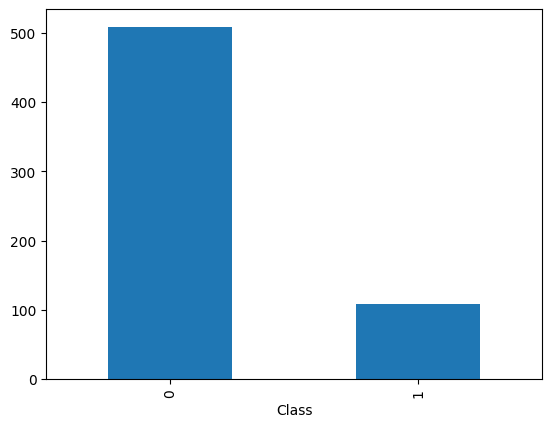

In [7]:
train_df['Class'].value_counts().plot(kind='bar');

In [8]:
df = pd.DataFrame(train_df['Class'].value_counts())
df['pct'] = np.round((train_df['Class'].value_counts()/train_df.shape[0]).values * 100, 4)
df

,count,pct
Class,,
0,509,82.4959
1,108,17.5041


In [9]:
neg, pos = np.bincount(train_df['Class'])
total = neg + pos
weight_for_0 = (1/neg) * (total / 2.0)
weight_for_1 = (1/pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print(f"Weight for class 0: {weight_for_0:.2f}")
print(f"Weight for class 1: {weight_for_1:.2f}")

Weight for class 0: 0.61
Weight for class 1: 2.86


In [ ]:
BAGS = 20
FOLDS = 11
oof = np.zeros(len(train_df))
models = {}
# scaler = preprocessing.QuantileTransformer(n_quantiles=60, output_distribution='uniform')

for bag in tqdm(range(BAGS)):
    print('#'*25)
    print('### Bag ', bag+1)
    print('#'*25)
    models[bag] = []
    skf = model_selection.StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=bag)
    
    for fold, (tr_idx, val_idx) in enumerate(skf.split(X=train_df[FEATURES], y=train_df['Class'])):
        print(f"=> Fold {fold+1}", end=' ')
        
        # Downsample negative class to balance classes
        y_train = train_df.loc[tr_idx, 'Class']
        RMV = y_train.loc[y_train==0].sample(
            frac=0.7, random_state=bag*BAGS+fold).index.values
        tr_idx = np.setdiff1d(tr_idx, RMV)
        
        # train data
        X_train = train_df.loc[tr_idx, FEATURES]
        y_train = train_df.loc[tr_idx, 'Class']
        
        # valid data
        X_valid = train_df.loc[val_idx, FEATURES]
        y_valid = train_df.loc[val_idx, 'Class']
        
#         X_train = scaler.fit_transform(X_train)
#         X_valid = scaler.transform(X_valid)
        
        # Train model
#         clf = ensemble.HistGradientBoostingClassifier(class_weight=class_weight)
        
        # sample weights for examples
        # compute the class weights
        weights = compute_class_weight('balanced', classes=[0, 1], y=y_train)

        # create a dictionary mapping class labels to weights
        weight_dict = dict(zip([0, 1, 2], weights))

        # assign sample weights based on class labels
        sample_weights = [weight_dict[yi] for yi in y_train]
        clf = xgb.XGBClassifier()
        clf.fit(X_train, y_train, sample_weight=sample_weights)
        
        # Hist Gradient oof predictions
        oof[val_idx] += clf.predict_proba(X_valid)[:, 1]/BAGS
        models[bag].append(clf)

In [11]:
def balance_logloss(y_true, y_pred):
    y_pred = np.stack([1-y_pred, y_pred]).T
    y_pred = np.clip(y_pred, 1e-15, 1-1e-15)
    y_pred / np.sum(y_pred, axis=1)[:, None]
    nc = np.bincount(y_true)
    
    logloss = (-1/nc[0]*(np.sum(np.where(y_true==0,1,0) * np.log(y_pred[:,0]))) - 1/nc[1]*(np.sum(np.where(y_true!=0,1,0) * np.log(y_pred[:,1])))) / 2
    
    return logloss

m = balance_logloss(train_df.Class.values, oof)
print('CV score: ', m)

CV score:  0.23028912999278933


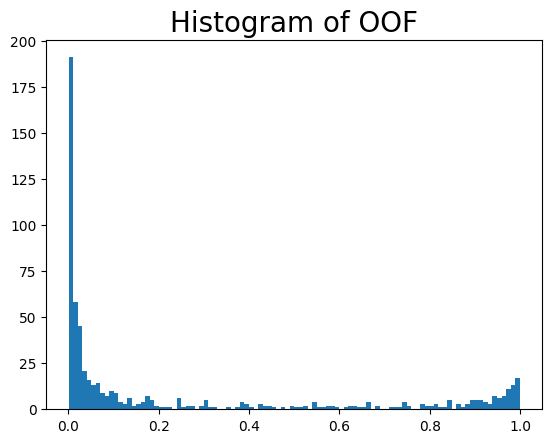

In [12]:
plt.hist(oof, bins=100)
plt.title('Histogram of OOF', size=20)
plt.show()

In [13]:
for c in test_df.columns.tolist()[1:]:
    m = means[c]
    s = stds[c]
    n = nans[c]
    
    test_df[c] = (test_df[c] - m)/s
    test_df[c] = test_df[c].fillna(n)
    
test_df

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL
0,00eed32682bb,-1.018705,-1.522401,-0.927922,-0.558863,-0.962863,-2.173291,-0.144715,-2.428708,-0.123575,...,-3.446146,-0.472606,-0.070422,-0.322899,-2.074164,-0.913536,-0.758519,-3.192311,-1.394807,-0.826082
1,010ebe33f668,-1.018705,-1.522401,-0.927922,-0.558863,-0.962863,-2.173291,-0.144715,-2.428708,-0.123575,...,-3.446146,-0.472606,-0.070422,-0.322899,-2.074164,-0.913536,-0.758519,-3.192311,-1.394807,-0.826082
2,02fa521e1838,-1.018705,-1.522401,-0.927922,-0.558863,-0.962863,-2.173291,-0.144715,-2.428708,-0.123575,...,-3.446146,-0.472606,-0.070422,-0.322899,-2.074164,-0.913536,-0.758519,-3.192311,-1.394807,-0.826082
3,040e15f562a2,-1.018705,-1.522401,-0.927922,-0.558863,-0.962863,-2.173291,-0.144715,-2.428708,-0.123575,...,-3.446146,-0.472606,-0.070422,-0.322899,-2.074164,-0.913536,-0.758519,-3.192311,-1.394807,-0.826082
4,046e85c7cc7f,-1.018705,-1.522401,-0.927922,-0.558863,-0.962863,-2.173291,-0.144715,-2.428708,-0.123575,...,-3.446146,-0.472606,-0.070422,-0.322899,-2.074164,-0.913536,-0.758519,-3.192311,-1.394807,-0.826082


In [14]:
preds = np.zeros(len(test_df))

for bag in range(BAGS):
    for clf in models[bag]:
        X_test = test_df[FEATURES]
        preds += clf.predict_proba(X_test)[:, 1] / FOLDS / BAGS

In [15]:
sample_df['class_0'] = 1 - preds
sample_df['class_1'] = preds

sample_df.to_csv('submission.csv', index=False)
pd.read_csv('submission.csv')

,Id,class_0,class_1
0,00eed32682bb,0.696316,0.303684
1,010ebe33f668,0.696316,0.303684
2,02fa521e1838,0.696316,0.303684
3,040e15f562a2,0.696316,0.303684
4,046e85c7cc7f,0.696316,0.303684
